# House Prices: Regression

Based on the exploratory notebook, I will start building models in this one. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%xmode minimal

Exception reporting mode: Minimal


In [2]:
path = "/Users/rmyazdi/Documents/kaggle/house_prices/data/{fname}"
train = pd.read_csv(path.format(fname="train.csv"))
test = pd.read_csv(path.format(fname="test.csv"))

## Baseline Model
For a baseline model, let's consider that that only factor going into the price of a house, is its overall land area as given by _LotArea_. Through trial and error, I ended up choosing a model that takes _LotArea_ and _sqrt(LotArea)_ as features.

In [3]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin

Text(0, 0.5, 'Sale Price, USD')

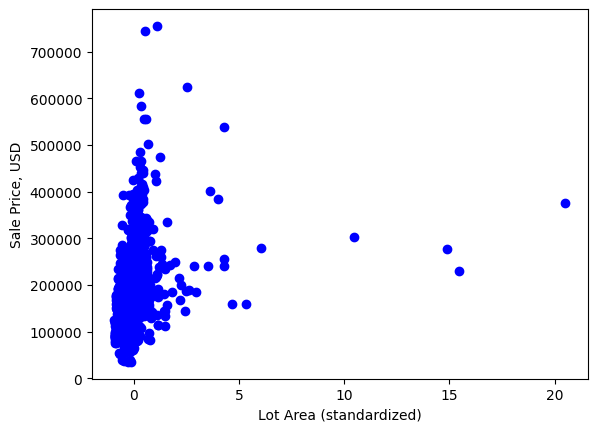

In [4]:
X_train, Y_train = train.LotArea, train.SalePrice
mean_x, std_x = X_train.mean(), X_train.std()
X_train = (X_train - mean_x)/std_x
fig, ax = plt.subplots(1,1)
ax.scatter(X_train, Y_train, color="blue")
ax.set_xlabel("Lot Area (standardized)")
ax.set_ylabel("Sale Price, USD")

I did a quick search and the largest estate in the United States is the Tillmore Manor which is approximately 175000 sq.ft. So here, I'll cut out all data points that are above 50,000 sq.ft. I checked Wikipedia for the largest houses in US and Iowa was not on the list.

In [5]:
train_cut = train[train.LotArea <= 50_000]

In [57]:
X_train, Y_train = np.log(train_cut.LotArea), np.log(train_cut.SalePrice)
Y = Y_train.to_numpy().reshape(-1, 1)

Create a pipeline now. I want to add the square-root feature column to the input data, then standardize the columns and apply a linear regression model.

In [71]:
class AddFractionalPower(BaseEstimator,TransformerMixin):
    def __init__(self, fpower=0.5):
        self.fpower = fpower
        
    def add_fpower(self,X,y=None):
        if not isinstance(X, np.ndarray):
            x = X.to_numpy()
        x = np.c_[X, np.power(X, self.fpower)]
        return x.reshape(len(x), -1)
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return self.add_fpower(X)
        
model = Pipeline([("fpower", AddFractionalPower()),
                    ("scaler", StandardScaler()), 
                    ("model", linear_model.LinearRegression())])


In [72]:
model.fit(X_train, Y)
Rscore = model.score(X_train, Y)
print(f"{Rscore = :0.3f}")

Rscore = 0.164


Text(0.5, 1.0, 'Baseline prediction')

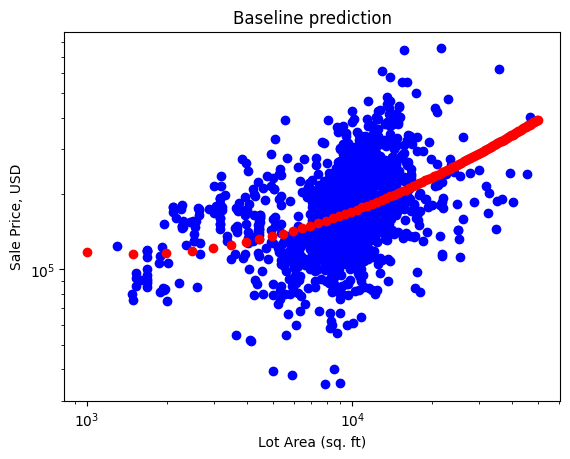

In [73]:
fig, ax = plt.subplots(1,1)
XX = np.linspace(1000, 50000, 100)
ax.scatter(np.exp(X_train), np.exp(Y_train), color="blue")
ax.scatter(XX, np.exp(model.predict(np.log(XX.reshape(-1, 1)))), color='red')
ax.set_xlabel("Lot Area (sq. ft)")
ax.set_ylabel("Sale Price, USD")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Baseline prediction")

In [79]:
X_test = np.log(test.LotArea).to_numpy().reshape(-1, 1)
test_predictions = model.predict(X_test)
test_predictions = np.exp(test_predictions)

In [83]:
with open("../submission.csv", "w") as f:
    f.write("Id,SalePrice\n")
    for i, sale in zip(test.Id, test_predictions):
        f.write(f"{i},{sale[0]:0.5f}\n")
        

This simple linear model with a sqrt feature gives an RMSE score of "0.39145" upon submission on Kaggle. This is the score to beat!